In [1]:
# libraries

import nibabel as nib
import matplotlib.pyplot as plt
import json
import pandas as pd
import numpy as np
import sys
import numpy
import tensorflow as tf
numpy.set_printoptions(threshold=sys.maxsize)
from sklearn.metrics import precision_score, recall_score, confusion_matrix,classification_report,roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [2]:
sys.path.append('/path/to/2014_07_13_test')
import generate_input
import batch_load_preprocess

case_00000 case_00043 case_00086 case_00129 case_00172 case_00215 case_00258
case_00001 case_00044 case_00087 case_00130 case_00173 case_00216 case_00259
case_00002 case_00045 case_00088 case_00131 case_00174 case_00217 case_00260
case_00003 case_00046 case_00089 case_00132 case_00175 case_00218 case_00261
case_00004 case_00047 case_00090 case_00133 case_00176 case_00219 case_00262
case_00005 case_00048 case_00091 case_00134 case_00177 case_00220 case_00263
case_00006 case_00049 case_00092 case_00135 case_00178 case_00221 case_00264
case_00007 case_00050 case_00093 case_00136 case_00179 case_00222 case_00265
case_00008 case_00051 case_00094 case_00137 case_00180 case_00223 case_00266
case_00009 case_00052 case_00095 case_00138 case_00181 case_00224 case_00267
case_00010 case_00053 case_00096 case_00139 case_00182 case_00225 case_00268
case_00011 case_00054 case_00097 case_00140 case_00183 case_00226 case_00269
case_00012 case_00055 case_00098 case_00141 case_00184 case_00227 case_00270

## Load model

In [3]:
# load validation set
val_case = ['case_00233', 'case_00089', 'case_00050', 'case_00112', 'case_00258', 'case_00246', 'case_00157', 'case_00149','case_00184']
test_case = ['case_00221', 'case_00259', 'case_00087', 'case_00254', 'case_00098', 'case_00023', 'case_00041',
             'case_00080', 'case_00101', 'case_00164', 'case_00002', 'case_00110', 'case_00030', 'case_00068',
             'case_00026', 'case_00063', 'case_00006', 'case_00048', 'case_00250', 'case_00238',
             'case_00111', 'case_00278', 'case_00133', 'case_00284', 'case_00282', 'case_00269', 'case_00039',
             'case_00033', 'case_00108', 'case_00175', 'case_00161', 'case_00256', 'case_00119', 'case_00286',
             'case_00077', 'case_00162', 'case_00270', 'case_00271', 'case_00285', 'case_00174', 'case_00147',
             'case_00215', 'case_00150', 'case_00052', 'case_00231', 'case_00198', 'case_00117', 'case_00138',
             'case_00211', 'case_00190', 'case_00248', 'case_00235', 'case_00049', 'case_00074', 'case_00107',
             'case_00218', 'case_00001', 'case_00193', 'case_00067', 'case_00072', 'case_00044',
             'case_00294', 'case_00298', 'case_00263', 'case_00038', 'case_00299', 'case_00249', 'case_00225',
             'case_00217', 'case_00178', 'case_00082', 'case_00035', 'case_00034', 'case_00047', 'case_00276',
             'case_00151', 'case_00226', 'case_00086', 'case_00176']

In [4]:
# load json and create model
json_file = open('model64croped_segmented3.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = tf.keras.models.model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model64croped_segmented3.h5")

Metal device set to: Apple M2 Pro


2023-05-13 20:37:50.205282: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-13 20:37:50.205444: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
# evaluate loaded model on test data
optimizer_fn = tf.keras.optimizers.experimental.RMSprop(learning_rate=0.001, jit_compile = False)
metrics_list = [tf.keras.metrics.AUC(name = 'auc'),
                tf.keras.metrics.BinaryAccuracy(name = 'accuracy')]
loaded_model.compile(optimizer = optimizer_fn, loss='binary_crossentropy', metrics= metrics_list)

## Load data

In [6]:
def generate_part_label_dict(labels_dict, list_of_cases):
    """ Generate lists of pathes to the right files """
    return {k: labels_dict[k] for k in list_of_cases}

def load_data(rootdir, img_dir, json_path, list_cases, isLabels = False):
     """ Load data in the right format """
    val_path = generate_input.processed_image_paths(rootdir, img_dir)
    labels_dict = generate_input.malignant_labels_to_dict(json_path)
    labels_dict_short = generate_part_label_dict(labels_dict, list_cases)
    image_dict_short = generate_input.load_nifti_img_and_mask_as_numpy(val_path, list_cases)
    x_set, y_set, labels_val = generate_input.fill_set(list_cases, labels_dict_short, image_dict_short, labels_dict, True)
    
    x_set = generate_input.adding_channel(x_set)
    if isLabels == True:
        return x_set, y_set, labels_val
    else:
        return x_set, y_set
    

def empty_image_removal_dict(masks, images):
     """ Removes padding of 0 from images and masks """
    x_final_dict = {}
    
    common_keys = masks.keys() & images.keys()
    for key in common_keys:
        x_final = []

        for i, pair in enumerate(zip(masks[key], images[key])):
    
            if len(np.unique(pair[0])) > 1:
                x_final.append(pair[1])
            
        x_final = np.array(x_final)

        
        x_final_dict[key] = x_final
    return x_final_dict

def adding_channel_dict(image_dict):
    """Convert from one channel to three channel images that are stored in dictionary """
    for key in image_dict:
        image_dict[key] = generate_input.adding_channel(image_dict[key])
    return image_dict

def load_data_to_evaluate_by_majority_voting(rootdir, img_dir, json_path, list_cases):
    """ Load images and labels in dictionary format """
    val_path = generate_input.processed_image_paths(rootdir, img_dir)
    labels_dict = generate_input.malignant_labels_to_dict(json_path)
    labels_dict_short = generate_part_label_dict(labels_dict, list_cases)
    labels_dict_short = {key: float(value) for key, value in labels_dict_short.items()}
    
    image_dict_short = generate_input.load_nifti_img_and_mask_as_numpy(val_path, list_cases)
    image_dict_short = adding_channel_dict(image_dict_short)
    return image_dict_short, labels_dict_short
    
def create_prediction_dict(image_dict, model):
    """ Create dictionary with prediction on patient-level using majority voting """
    pred_dict = {}
    for key in image_dict:
        y_pred = model.predict(image_dict[key])
        pred_dict[key] = np.round(np.sum(y_pred)/len(y_pred))
    return pred_dict

def create_true_and_prediction_lists(true_dict, pred_dict):
    """ Convert dictionaries into lists for evaluation """
    common_keys = true_dict.keys() & pred_dict.keys()
    true_lst = []
    pred_lst = [] 
    key_lst = []
    for key in common_keys:
        true_lst.append(true_dict[key])
        pred_lst.append(pred_dict[key])   
        key_lst.append(key)
    return true_lst, pred_lst,key_lst

def empty_image_removal(masks, images, labels, cases):
     """ Removes padding of 0 from images and masks """
    x_final = []
    y_final = []
    cases_final = []

    for i, pair in enumerate(zip(masks, images, labels,cases)):
    
        if len(np.unique(pair[0])) > 1:
            x_final.append(pair[1])
            y_final.append(pair[2])
            cases_final.append(pair[3])
            
    x_final = np.array(x_final)
    y_final = np.array(y_final)
    cases_final = np.array(cases_final)
    return x_final, y_final, cases_final

In [14]:
test_dict, test_label_dict = load_data_to_evaluate_by_majority_voting('./cropped-data/', 'images-64', '../kits21/kits21/data/kits.json', test_case)

In [15]:
test_dict_masks, test_label = load_data_to_evaluate_by_majority_voting('./cropped-data/', 'masks-64', '../kits21/kits21/data/kits.json', test_case)

In [16]:
test_dict_short = empty_image_removal_dict(test_dict_masks, test_dict)

In [18]:
test_pred_dict = create_prediction_dict(test_dict_short, loaded_model)

2/2 [==============================] - 0s 330ms/step


In [19]:
# number of slices in each 3D array
number_slices = {}
for i in test_case:
    print()
    number_slices[i] = test_dict_short[i].shape[0]

In [21]:
print(number_slices[min(number_slices, key=number_slices.get)])
print(number_slices[max(number_slices, key=number_slices.get)])

20
128


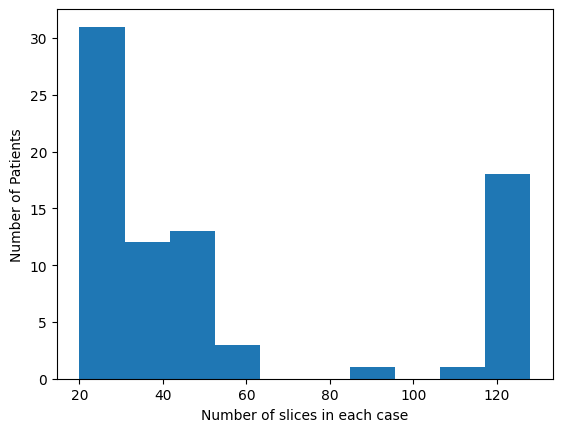

In [22]:
plt.hist(number_slices.values())
plt.xlabel('Number of slices in each case')
plt.ylabel('Number of Patients')
plt.show()

In [23]:
x_test, y_test, labels_test = load_data('./cropped-data/', 'images-64', '../kits21/kits21/data/kits.json', test_case, True)

In [24]:
x_test_mask, y_test_mask, labels_test = load_data('./cropped-data/', 'masks-64', '../kits21/kits21/data/kits.json', test_case, True)

In [25]:
x_test_final, y_test_final, cases_final = empty_image_removal(x_test_mask, x_test, y_test, labels_test)

In [26]:
x_test_final.shape

(4456, 64, 64, 3)

In [27]:
y_pred_test = loaded_model.predict(x_test_final)

140/140 [==============================] - 2s 15ms/step


In [29]:
# count cases that were predicted correctly and not
count_plus = {}
count_neg = {}
for i in zip(y_test_final,  y_pred_test.round(), cases_final):
    if i[2] not in count_plus:
        count_plus[i[2]] = 0
    if i[2] not in count_neg:
        count_neg[i[2]] = 0

    if i[0] == i[1]:
        count_plus[i[2]] += 1
    else:
        count_neg[i[2]] += 1
        
dict_neg = count_neg

In [30]:
test_true_lst, test_pred_lst, test_keys = create_true_and_prediction_lists(test_label_dict, test_pred_dict)

In [31]:
# count cases that were predicted correctly and not on patient level
count_plus_maj = {}
count_neg_maj = {}
for i in zip(test_true_lst,  test_pred_lst, test_keys):
    if i[2] not in count_plus_maj:
        count_plus_maj[i[2]] = 0
    if i[2] not in count_neg_maj:
        count_neg_maj[i[2]] = 0

    if i[0] == i[1]:
        count_plus_maj[i[2]] += 1
    else:
        count_neg_maj[i[2]] += 1
        
neg_predicted_cases = count_neg_maj

## Results analysis

In [32]:
linkMetadata = '../kits21/kits21/data/kits.json'
dataJson = json.load(open(linkMetadata))
df = pd.json_normalize(dataJson)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 63 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   case_id                                                   300 non-null    object 
 1   age_at_nephrectomy                                        300 non-null    int64  
 2   gender                                                    300 non-null    object 
 3   body_mass_index                                           300 non-null    float64
 4   smoking_history                                           300 non-null    object 
 5   age_when_quit_smoking                                     265 non-null    object 
 6   pack_years                                                194 non-null    object 
 7   chewing_tobacco_use                                       300 non-null    object 
 8   alcohol_use         

In [33]:
# check number of cases by subtype
df.groupby(['malignant','tumor_histologic_subtype'])['tumor_histologic_subtype'].count()

malignant  tumor_histologic_subtype 
False      angiomyolipoma                 5
           mest                           3
           oncocytoma                    16
           spindle_cell_neoplasm          1
True       chromophobe                   27
           clear_cell_papillary_rcc       7
           clear_cell_rcc               204
           collecting_duct_undefined      1
           multilocular_cystic_rcc        1
           other                          1
           papillary                     28
           rcc_unclassified               2
           urothelial                     3
           wilms                          1
Name: tumor_histologic_subtype, dtype: int64

In [34]:
# add columns to data
df['numberNegativePred'] = df['case_id'].map(dict_neg)
df['numberSlices'] = df['case_id'].map(number_slices)
df['negPredictedcases'] = df['case_id'].map(neg_predicted_cases)

## check share of incorrectly predicted slices in each case

In [35]:
# share of incorrectly predicted slices in each case
df_small = df[['case_id','malignant','tumor_histologic_subtype', 'numberNegativePred', 'numberSlices', 'negPredictedcases']]

incorrectly_predicted_slices = df_small.groupby(['malignant','tumor_histologic_subtype', 'case_id'])['numberNegativePred'].sum() # negative pred
sclices_by_case = df_small.groupby(['malignant','tumor_histologic_subtype', 'case_id'])['numberSlices'].sum() # all slices

incorrectly_predicted_slices = incorrectly_predicted_slices[incorrectly_predicted_slices>0]
sclices_by_case = sclices_by_case[sclices_by_case>0]

share_of_incorrect_slices = incorrectly_predicted_slices*100/sclices_by_case
share_of_incorrect_slices = share_of_incorrect_slices.reset_index(drop=False)
share_of_incorrect_slices


,malignant,tumor_histologic_subtype,case_id,0
0,False,angiomyolipoma,case_00176,7.692308
1,False,mest,case_00133,75.000000
2,False,mest,case_00211,93.877551
3,False,oncocytoma,case_00077,100.000000
4,False,oncocytoma,case_00082,94.871795
...,...,...,...,...
74,True,papillary,case_00068,77.343750
75,True,papillary,case_00108,NaN
76,True,papillary,case_00162,NaN
77,True,papillary,case_00215,NaN


In [36]:
# check where share is bigger than 90%
round(share_of_incorrect_slices[share_of_incorrect_slices[0]>90],2)

,malignant,tumor_histologic_subtype,case_id,0
2,False,mest,case_00211,93.88
3,False,oncocytoma,case_00077,100.00
4,False,oncocytoma,case_00082,94.87
53,True,clear_cell_rcc,case_00231,90.48


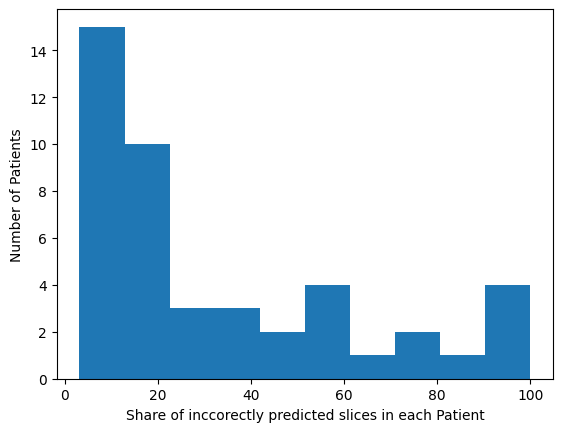

In [37]:
plt.hist(share_of_incorrect_slices[0])
plt.xlabel('Share of inccorectly predicted slices in each Patient')
plt.ylabel('Number of Patients')
plt.show() # how big share of the case was wrongly predicted 

## misclassified cases on patient-level

In [38]:
# all test cases grouped
all_cases_in_test = df_small.groupby(['malignant','tumor_histologic_subtype'])['numberNegativePred'].count()
all_cases_in_test

df_cases = df.dropna(axis='index', subset=['negPredictedcases']) 
df_cases = df_cases.reset_index(drop=True)

# take only needed columns
df_cases = df_cases[['case_id','malignant','tumor_histologic_subtype', 'numberNegativePred', 'numberSlices', 'negPredictedcases']]
df_cases.groupby(['malignant','tumor_histologic_subtype'])['negPredictedcases'].sum() * 100 / all_cases_in_test

malignant  tumor_histologic_subtype 
False      angiomyolipoma                 0.000000
           mest                         100.000000
           oncocytoma                    50.000000
           spindle_cell_neoplasm               NaN
True       chromophobe                    0.000000
           clear_cell_papillary_rcc       0.000000
           clear_cell_rcc                11.864407
           collecting_duct_undefined           NaN
           multilocular_cystic_rcc             NaN
           other                               NaN
           papillary                     11.111111
           rcc_unclassified                    NaN
           urothelial                          NaN
           wilms                               NaN
dtype: float64

In [68]:
df_cases.groupby(['malignant','tumor_histologic_subtype'])['negPredictedcases'].sum()

malignant  tumor_histologic_subtype
False      angiomyolipoma              0.0
           mest                        2.0
           oncocytoma                  2.0
True       chromophobe                 0.0
           clear_cell_papillary_rcc    0.0
           clear_cell_rcc              7.0
           papillary                   1.0
Name: negPredictedcases, dtype: float64

In [88]:
df_cases[df_cases.negPredictedcases > 0]

,case_id,malignant,tumor_histologic_subtype,numberNegativePred,numberSlices,negPredictedcases
19,case_00068,True,papillary,99.0,128.0,1.0
20,case_00072,True,clear_cell_rcc,46.0,55.0,1.0
22,case_00077,False,oncocytoma,31.0,31.0,1.0
24,case_00082,False,oncocytoma,37.0,39.0,1.0
35,case_00133,False,mest,36.0,48.0,1.0
38,case_00150,True,clear_cell_rcc,31.0,52.0,1.0
46,case_00178,True,clear_cell_rcc,14.0,24.0,1.0
50,case_00211,False,mest,46.0,49.0,1.0
57,case_00231,True,clear_cell_rcc,38.0,42.0,1.0
58,case_00235,True,clear_cell_rcc,18.0,39.0,1.0


## Check share of cases with at least one slice misclassified

In [71]:
# check what share from test cases were misclassified with at least one misclassified slice
df_test = df[['case_id','malignant','tumor_histologic_subtype', 'numberNegativePred', 'numberSlices']]
df_test = df.dropna(axis='index', subset=['numberNegativePred']) 
df_test = df_test.reset_index(drop=True)

negative_only = df_test[df_test['numberNegativePred']>0]
misclassfied_cases = negative_only.groupby(['malignant','tumor_histologic_subtype'])['numberNegativePred'].count()
misclassfied_cases / all_cases_in_test

malignant  tumor_histologic_subtype 
False      angiomyolipoma               1.000000
           mest                         1.000000
           oncocytoma                   1.000000
           spindle_cell_neoplasm             NaN
True       chromophobe                  0.333333
           clear_cell_papillary_rcc          NaN
           clear_cell_rcc               0.593220
           collecting_duct_undefined         NaN
           multilocular_cystic_rcc           NaN
           other                             NaN
           papillary                    0.222222
           rcc_unclassified                  NaN
           urothelial                        NaN
           wilms                             NaN
Name: numberNegativePred, dtype: float64

In [72]:
misclassfied_cases

malignant  tumor_histologic_subtype
False      angiomyolipoma               1
           mest                         2
           oncocytoma                   4
True       chromophobe                  1
           clear_cell_rcc              35
           papillary                    2
Name: numberNegativePred, dtype: int64

## Check what cases could be excluded

In [28]:
oncocytoma = df_small['tumor_histologic_subtype'] != 'oncocytoma'
clear_cell_rcc = df_small['tumor_histologic_subtype'] != 'clear_cell_rcc'
chromophobe = df_small['tumor_histologic_subtype'] != 'chromophobe'
papillary = df_small['tumor_histologic_subtype'] != 'papillary'

angiomyolipoma = df_small['tumor_histologic_subtype'] != 'angiomyolipoma'


n = df_small[(oncocytoma) & (clear_cell_rcc) & (chromophobe) &(papillary) &(angiomyolipoma)]
n.reset_index()

,index,case_id,malignant,tumor_histologic_subtype,numberNegativePred,numberSlices
0,18,case_00018,True,rcc_unclassified,NaN,NaN
1,31,case_00031,False,spindle_cell_neoplasm,NaN,NaN
2,42,case_00042,False,mest,NaN,NaN
3,56,case_00056,True,clear_cell_papillary_rcc,NaN,NaN
4,88,case_00088,True,wilms,NaN,NaN
5,90,case_00090,True,urothelial,NaN,NaN
6,92,case_00092,True,rcc_unclassified,NaN,NaN
7,106,case_00106,True,multilocular_cystic_rcc,NaN,NaN
8,120,case_00120,True,clear_cell_papillary_rcc,NaN,NaN
9,133,case_00133,False,mest,4.0,51.0


In [29]:
df[['case_id','malignant','tumor_histologic_subtype']][df['malignant'] == False]

,case_id,malignant,tumor_histologic_subtype
17,case_00017,False,angiomyolipoma
19,case_00019,False,oncocytoma
20,case_00020,False,oncocytoma
31,case_00031,False,spindle_cell_neoplasm
42,case_00042,False,mest
43,case_00043,False,angiomyolipoma
77,case_00077,False,oncocytoma
82,case_00082,False,oncocytoma
104,case_00104,False,oncocytoma
116,case_00116,False,oncocytoma


## Analysis of trust score

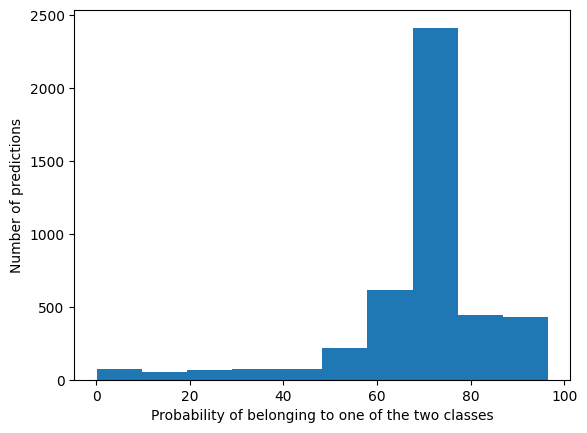

In [45]:
# change y test and stuff to the correct one
prediction = []
result = []
for i, pair in enumerate(zip(y_test_final, y_pred_test, cases_final)):
    prediction.append(pair[1].round())
    
    if pair[1] > 0.5:
        result.append(np.round(((pair[1]-0.5)/(1-0.5))*100, 2))
    else:
        result.append(np.round((((1-pair[1]) -0.5)/(1-0.5))*100, 2))

plt.hist(np.array(result ))
plt.xlabel('Probability of belonging to one of the two classes')
plt.ylabel('Number of predictions')
plt.show() 

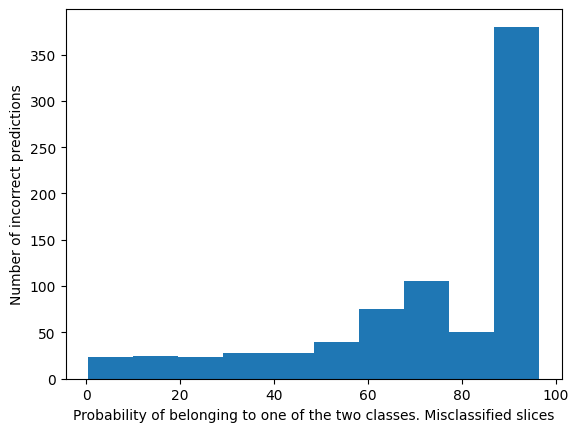

In [50]:
prediction_same = []
result_same = []
prediction_diff = []
result_diff = []
for i, pair in enumerate(zip(y_test_final, y_pred_test, cases_final)):
    #prediction.append(pair[1].round())

    if (pair[0] != pair[1].round()):
        prediction_diff.append(pair[1].round())
        if pair[1] > 0.5:
            result_diff.append(np.round(((pair[1]-0.5)/(1-0.5))*100, 2))
        else:
            result_diff.append(np.round((((1-pair[1]) -0.5)/(1-0.5))*100, 2))
    else:
        prediction_same.append(pair[1].round())
        if pair[1] > 0.5:
            result_same.append(np.round(((pair[1]-0.5)/(1-0.5))*100, 2))
        else:
            result_same.append(np.round((((1-pair[1]) -0.5)/(1-0.5))*100, 2))

plt.hist(np.array(result_diff ))
plt.xlabel('Probability of belonging to one of the two classes. Misclassified slices')
plt.ylabel('Number of incorrect predictions')
plt.show() 

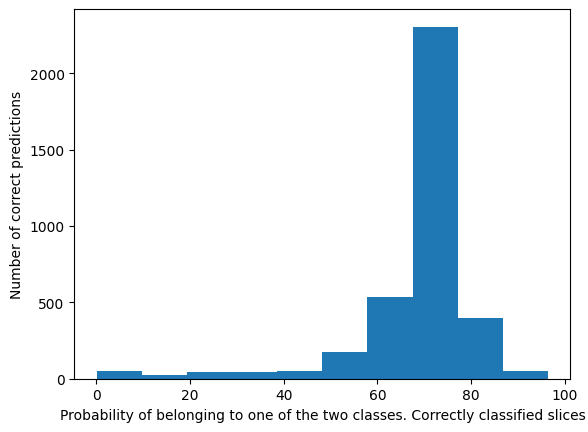

In [51]:
plt.hist(np.array(result_same ))
plt.xlabel('Probability of belonging to one of the two classes. Correctly classified slices')
plt.ylabel('Number of correct predictions')
plt.show() 